# Flora Chat Pareto Analysis

**Industrial Engineering approach to understanding Flora user behavior**

Analysis Goals:
1. **Accurate Intent Categorization** - What are users actually asking for?
2. **Pareto Analysis** - Which 20% of request types drive 80% of usage?
3. **First Prompt Distribution** - How do users enter Flora? (adoption signal)
4. **User Progression** - Do users evolve in their Flora usage?
5. **Engagement Depth** - Are users having conversations or one-shots?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
from pathlib import Path
from collections import Counter

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

DATA_DIR = Path("../data")

In [2]:
# Load cleaned data
df = pd.read_csv(DATA_DIR / "flora-chats-cleaned.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df)} messages from {df['userId'].nunique()} users across {df['sessionId'].nunique()} sessions")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")

Loaded 93 messages from 10 users across 73 sessions
Date range: 2025-12-10 to 2026-01-09


---
## 1. Accurate Intent Categorization

**Methodology:** Extract the ACTION (verb) + TARGET (object) from each instruction to create accurate categories.

This avoids the keyword-matching trap where "sprint" appearing anywhere = "Sprint Planning".

In [ ]:
def categorize_intent(instruction):
    """
    Categorize user intent based on action verbs and targets.
    
    Returns: (category, confidence, reasoning)
    """
    if pd.isna(instruction) or str(instruction).strip() == '':
        return ('Empty Input', 'high', 'No instruction provided')
    
    text = str(instruction).lower().strip()
    
    # Pattern 1: Executive/Summary Requests
    if re.search(r'(provide|give|generate|create).*(executive|summary|overview|report)', text):
        return ('Executive Reporting', 'high', 'Requests summary/executive report')
    
    # Pattern 2: Data Analysis Requests (with JSON payload)
    if re.search(r'analyze.*(following|this|the).*data', text):
        return ('Data Analysis', 'high', 'Requests analysis of provided data')
    
    # Pattern 3: Sprint Retrospective/Analysis
    if re.search(r'(sprint|retro|retrospective).*(analysis|review)', text):
        return ('Sprint Retrospective', 'high', 'Requests sprint retrospective analysis')
    
    # Pattern 4: Velocity/Metrics Queries (expanded)
    if re.search(r'(velocity|throughput|burndown|metrics|readiness|cycle.?time|lead.?time|rework)', text):
        return ('Metrics Query', 'high', 'Requests specific metrics')
    
    # Pattern 4b: Quantity questions about work items
    if re.search(r'how many.*(points|tasks|stories|items|cards)', text):
        return ('Metrics Query', 'high', 'Quantity question about metrics')
    
    # Pattern 5: Information Requests (conversational, expanded)
    if re.search(r'^(tell me|what is|what are|describe|explain|show me|can you show|what action)', text):
        return ('Information Request', 'high', 'Asks for information/explanation')
    
    # Pattern 6: Performance Analysis
    if re.search(r'performance.*(analysis|review|check)', text):
        return ('Performance Analysis', 'medium', 'Requests performance analysis')
    
    # Pattern 6b: Performance trend questions
    if re.search(r'(why|how).*(decreas|increas|perform|trend)', text):
        return ('Performance Analysis', 'medium', 'Performance trend question')
    
    # Pattern 7: Work Period / Sprint Context Queries
    if re.search(r'(for|about).*(work.?period|sprint|\[ref\])', text):
        if re.search(r'(summary|report|overview)', text):
            return ('Sprint Reporting', 'medium', 'Requests report for specific sprint')
        else:
            return ('Sprint Query', 'medium', 'Query about specific sprint')
    
    # Pattern 8: Initiative/Project Queries
    if re.search(r'(initiative|project|epic)', text):
        return ('Initiative Query', 'medium', 'Query about initiative/project')
    
    # Pattern 9: Generic Analysis Request
    if re.search(r'^analyze', text):
        return ('General Analysis', 'medium', 'Generic analysis request')
    
    # Pattern 10: Remaining conversational questions
    if re.search(r'^(can you|could you|show|how|what)\b', text):
        return ('Information Request', 'medium', 'Conversational question')
    
    # Fallback: Unclassified
    return ('Unclassified', 'low', f'No pattern matched')

# Apply categorization
categorization = df['instruction'].apply(categorize_intent)
df['intent_category'] = categorization.apply(lambda x: x[0])
df['category_confidence'] = categorization.apply(lambda x: x[1])
df['category_reasoning'] = categorization.apply(lambda x: x[2])

print("=== INTENT DISTRIBUTION ===")
print(df['intent_category'].value_counts())
print()
print(f"High confidence: {(df['category_confidence'] == 'high').sum()} ({(df['category_confidence'] == 'high').mean()*100:.1f}%)")
print(f"Medium confidence: {(df['category_confidence'] == 'medium').sum()} ({(df['category_confidence'] == 'medium').mean()*100:.1f}%)")
print(f"Low confidence: {(df['category_confidence'] == 'low').sum()} ({(df['category_confidence'] == 'low').mean()*100:.1f}%)")

In [4]:
# VALIDATION: Show samples for each category
print("=" * 80)
print("VALIDATION SAMPLES - Review these to confirm accuracy")
print("=" * 80)

for category in df['intent_category'].unique():
    print(f"\n### {category} ###")
    samples = df[df['intent_category'] == category].head(3)
    for i, (_, row) in enumerate(samples.iterrows(), 1):
        instr = str(row['instruction'])[:100] if len(str(row['instruction'])) > 100 else str(row['instruction'])
        print(f"  {i}. [{row['category_confidence']}] {instr}")
        print(f"     Reason: {row['category_reasoning']}")

VALIDATION SAMPLES - Review these to confirm accuracy

### Information Request ###
  1. [high] Tell me about this initiative
     Reason: Asks for information/explanation
  2. [high] tell me about this initiative
     Reason: Asks for information/explanation
  3. [high] Explain to me for BDC Tools the cycle time trends for the last 30 days from November 1st to December
     Reason: Asks for information/explanation

### Executive Reporting ###
  1. [high] For work period 'REBEL-2025 SP26' provide Executive Summary, Sprint Retro Analysis, and Performance 
     Reason: Requests summary/executive report
  2. [high] Analyze the following data and provide a concise summary of the key findings. Keep your response in 
     Reason: Requests summary/executive report
  3. [high] Analyze the following data and provide a concise summary of the key findings. Keep your response in 
     Reason: Requests summary/executive report

### Metrics Query ###
  1. [high] Throughput and Velocity Comparisons
  

---
## 2. Pareto Analysis - Request Types

**The 80/20 Rule:** Which request types account for the majority of Flora usage?

In [5]:
def create_pareto_chart(data, title, xlabel='Category', color='#2E86AB', figsize=(12, 6)):
    """
    Create a professional Pareto chart.
    """
    # Sort descending
    data = data.sort_values(ascending=False)
    
    # Calculate cumulative percentage
    total = data.sum()
    cumulative_pct = data.cumsum() / total * 100
    
    # Find 80% threshold
    threshold_idx = (cumulative_pct <= 80).sum()
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Bar chart
    x = range(len(data))
    bars = ax1.bar(x, data.values, color=color, alpha=0.85, edgecolor='white', linewidth=0.7)
    
    # Highlight the 80% bars (vital few)
    for i, bar in enumerate(bars):
        if i < threshold_idx:
            bar.set_color('#E63946')  # Red for vital few
            bar.set_alpha(0.9)
    
    ax1.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=12, fontweight='bold', color=color)
    ax1.set_xticks(x)
    ax1.set_xticklabels(data.index, rotation=45, ha='right', fontsize=10)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Add count labels on bars
    for i, (v, pct) in enumerate(zip(data.values, data.values/total*100)):
        ax1.text(i, v + 0.5, f'{v}\n({pct:.0f}%)', ha='center', va='bottom', fontsize=9)
    
    # Cumulative line (secondary axis)
    ax2 = ax1.twinx()
    ax2.plot(x, cumulative_pct.values, 'o-', color='#1D3557', linewidth=2.5, markersize=6)
    ax2.set_ylabel('Cumulative %', fontsize=12, fontweight='bold', color='#1D3557')
    ax2.tick_params(axis='y', labelcolor='#1D3557')
    ax2.set_ylim(0, 105)
    
    # 80% reference line
    ax2.axhline(y=80, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(len(data)-1, 82, '80% threshold', color='#E63946', fontsize=10, ha='right')
    
    # Title
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Vital few annotation
    vital_few_pct = cumulative_pct.iloc[threshold_idx-1] if threshold_idx > 0 else 0
    if threshold_idx > 0:
        ax1.annotate(f'Vital Few: {threshold_idx} categories\n= {vital_few_pct:.0f}% of requests',
                    xy=(threshold_idx-0.5, data.iloc[threshold_idx-1]),
                    xytext=(threshold_idx+1, max(data)*0.7),
                    fontsize=10, color='#E63946',
                    arrowprops=dict(arrowstyle='->', color='#E63946', lw=1.5),
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#E63946'))
    
    plt.tight_layout()
    return fig, (ax1, ax2), {'vital_few_count': threshold_idx, 'vital_few_pct': vital_few_pct}

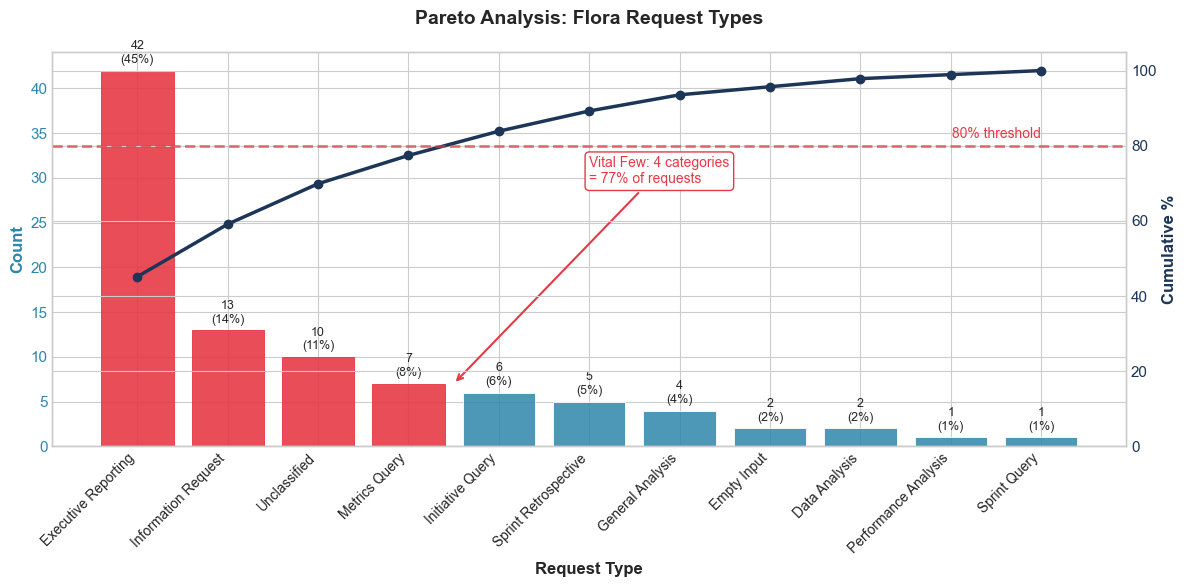


=== PARETO INSIGHT ===
The top 4 request types account for 77% of all Flora usage.

Vital Few (focus here for max impact):
  - Executive Reporting: 42 requests (45.2%)
  - Information Request: 13 requests (14.0%)
  - Unclassified: 10 requests (10.8%)
  - Metrics Query: 7 requests (7.5%)


In [6]:
# Pareto Chart: Intent Categories
intent_counts = df['intent_category'].value_counts()

fig, axes, stats = create_pareto_chart(
    intent_counts,
    'Pareto Analysis: Flora Request Types',
    'Request Type'
)

plt.savefig(DATA_DIR / 'pareto_request_types.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n=== PARETO INSIGHT ===")
print(f"The top {stats['vital_few_count']} request types account for {stats['vital_few_pct']:.0f}% of all Flora usage.")
print(f"\nVital Few (focus here for max impact):")
for cat in intent_counts.head(stats['vital_few_count']).index:
    count = intent_counts[cat]
    print(f"  - {cat}: {count} requests ({count/len(df)*100:.1f}%)")

---
## 3. Pareto Analysis - User Distribution

Who are the power users? Does the 80/20 rule apply to user activity?

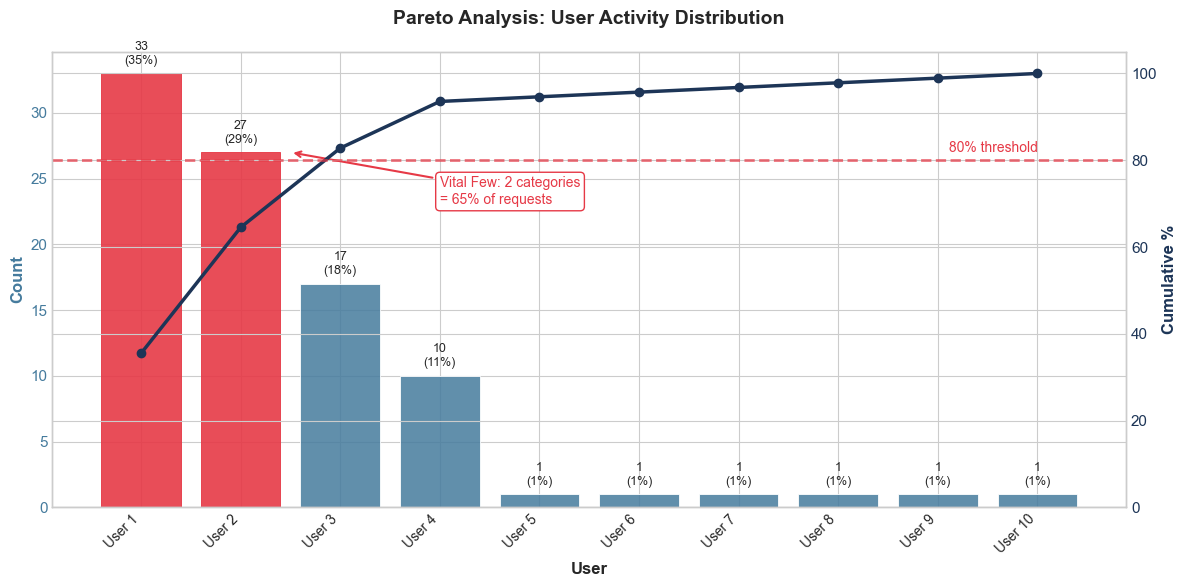


=== USER CONCENTRATION ===
The top 2 users account for 65% of all messages.
Total unique users: 10


In [7]:
# Pareto Chart: Users
user_counts = df['userId'].value_counts()
# Anonymize user IDs for display
user_counts_display = user_counts.copy()
user_counts_display.index = [f'User {i+1}' for i in range(len(user_counts))]

fig, axes, stats = create_pareto_chart(
    user_counts_display,
    'Pareto Analysis: User Activity Distribution',
    'User',
    color='#457B9D'
)

plt.savefig(DATA_DIR / 'pareto_user_activity.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n=== USER CONCENTRATION ===")
print(f"The top {stats['vital_few_count']} users account for {stats['vital_few_pct']:.0f}% of all messages.")
print(f"Total unique users: {len(user_counts)}")

---
## 4. First Prompt Analysis (Adoption Entry Point)

**What do users ask FIRST?** This reveals how users perceive Flora's value proposition.

Total first-in-session messages: 73
(These represent 73 unique conversation starts)


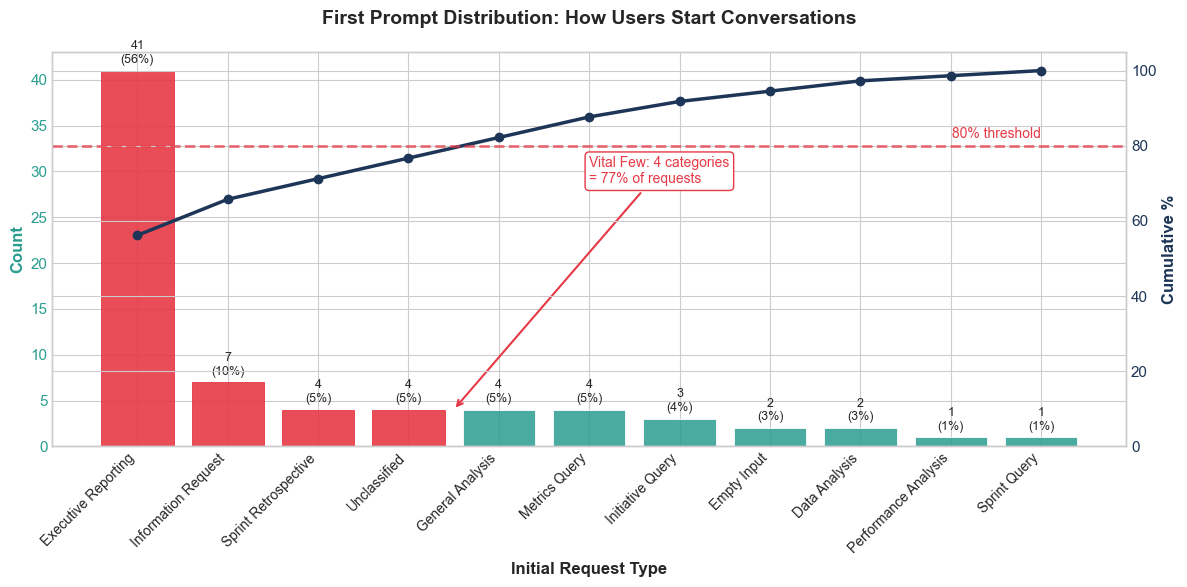


=== ADOPTION INSIGHT ===
Users predominantly enter Flora through: Executive Reporting

Top entry points:
  - Executive Reporting: 41 sessions (56.2%)
  - Information Request: 7 sessions (9.6%)
  - Sprint Retrospective: 4 sessions (5.5%)


In [8]:
# Filter to first messages only
first_messages = df[df['is_first_in_session'] == True].copy()

print(f"Total first-in-session messages: {len(first_messages)}")
print(f"(These represent {len(first_messages)} unique conversation starts)")

# Distribution of first prompts by category
first_prompt_dist = first_messages['intent_category'].value_counts()

fig, axes, stats = create_pareto_chart(
    first_prompt_dist,
    'First Prompt Distribution: How Users Start Conversations',
    'Initial Request Type',
    color='#2A9D8F'
)

plt.savefig(DATA_DIR / 'pareto_first_prompts.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n=== ADOPTION INSIGHT ===")
print(f"Users predominantly enter Flora through: {first_prompt_dist.index[0]}")
print(f"\nTop entry points:")
for cat, count in first_prompt_dist.head(3).items():
    print(f"  - {cat}: {count} sessions ({count/len(first_messages)*100:.1f}%)")

---
## 5. Engagement Depth Analysis

**Are users having multi-turn conversations or one-shot queries?**

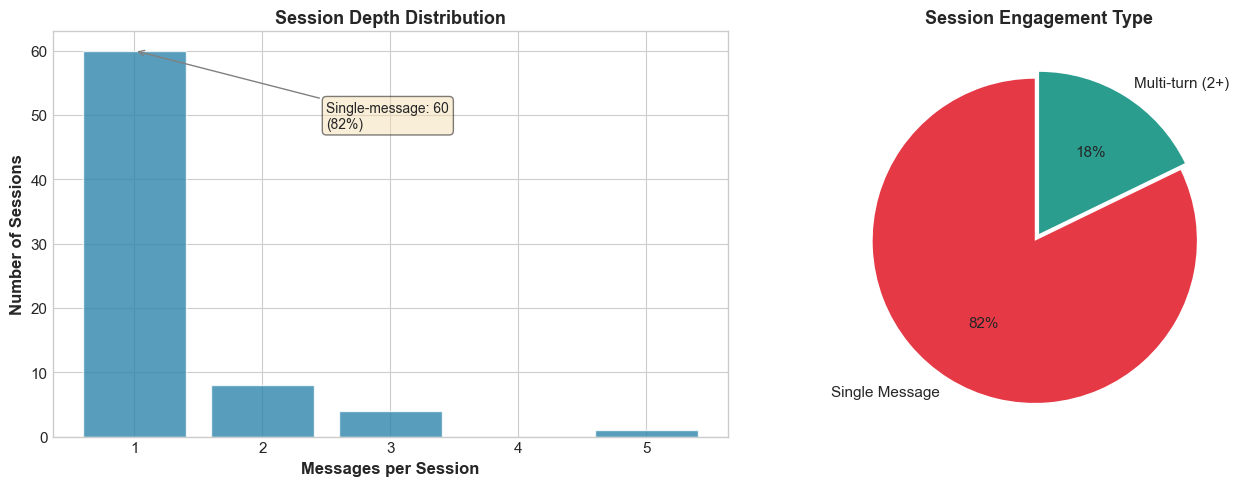


=== ENGAGEMENT INSIGHT ===
Average session depth: 1.27 messages
Single-message sessions: 60/73 (82%)
Multi-turn conversations: 13/73 (18%)


In [9]:
# Session depth distribution
session_depths = df.groupby('sessionId').size()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of session depths
ax1 = axes[0]
depth_counts = session_depths.value_counts().sort_index()
ax1.bar(depth_counts.index, depth_counts.values, color='#2E86AB', alpha=0.8, edgecolor='white')
ax1.set_xlabel('Messages per Session', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Sessions', fontsize=12, fontweight='bold')
ax1.set_title('Session Depth Distribution', fontsize=13, fontweight='bold')

# Add annotations
single_msg = (session_depths == 1).sum()
multi_msg = (session_depths > 1).sum()
ax1.annotate(f'Single-message: {single_msg}\n({single_msg/len(session_depths)*100:.0f}%)',
            xy=(1, depth_counts.get(1, 0)), xytext=(2.5, depth_counts.get(1, 0)*0.8),
            fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'),
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Pie chart: Single vs Multi-turn
ax2 = axes[1]
engagement_types = ['Single Message', 'Multi-turn (2+)']
engagement_counts = [single_msg, multi_msg]
colors = ['#E63946', '#2A9D8F']
explode = (0.05, 0)

wedges, texts, autotexts = ax2.pie(engagement_counts, labels=engagement_types, autopct='%1.0f%%',
                                   colors=colors, explode=explode, startangle=90,
                                   textprops={'fontsize': 11})
ax2.set_title('Session Engagement Type', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_DIR / 'engagement_depth.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n=== ENGAGEMENT INSIGHT ===")
print(f"Average session depth: {session_depths.mean():.2f} messages")
print(f"Single-message sessions: {single_msg}/{len(session_depths)} ({single_msg/len(session_depths)*100:.0f}%)")
print(f"Multi-turn conversations: {multi_msg}/{len(session_depths)} ({multi_msg/len(session_depths)*100:.0f}%)")

---
## 6. Export Analysis Results

In [10]:
# Compile analysis summary
analysis_results = {
    'overview': {
        'total_messages': len(df),
        'unique_users': int(df['userId'].nunique()),
        'unique_sessions': int(df['sessionId'].nunique()),
        'date_range': f"{df['timestamp'].min().date()} to {df['timestamp'].max().date()}"
    },
    'request_types': {
        'distribution': df['intent_category'].value_counts().to_dict(),
        'categorization_confidence': {
            'high': int((df['category_confidence'] == 'high').sum()),
            'medium': int((df['category_confidence'] == 'medium').sum()),
            'low': int((df['category_confidence'] == 'low').sum())
        }
    },
    'user_distribution': {
        'top_4_users_pct': round(df['userId'].value_counts().head(4).sum() / len(df) * 100, 1)
    },
    'engagement': {
        'avg_session_depth': round(session_depths.mean(), 2),
        'single_message_sessions_pct': round((session_depths == 1).sum() / len(session_depths) * 100, 1),
        'multi_turn_sessions_pct': round((session_depths > 1).sum() / len(session_depths) * 100, 1)
    },
    'first_prompt': {
        'distribution': first_messages['intent_category'].value_counts().to_dict()
    }
}

# Save results
with open(DATA_DIR / 'analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2, default=str)

# Save categorized data
df.to_csv(DATA_DIR / 'flora-chats-analyzed.csv', index=False)

print("=== ANALYSIS COMPLETE ===")
print(f"\nResults saved to:")
print(f"  - {DATA_DIR / 'analysis_results.json'}")
print(f"  - {DATA_DIR / 'flora-chats-analyzed.csv'}")
print(f"  - {DATA_DIR / 'pareto_request_types.png'}")
print(f"  - {DATA_DIR / 'pareto_user_activity.png'}")
print(f"  - {DATA_DIR / 'pareto_first_prompts.png'}")
print(f"  - {DATA_DIR / 'engagement_depth.png'}")

=== ANALYSIS COMPLETE ===

Results saved to:
  - ../data/analysis_results.json
  - ../data/flora-chats-analyzed.csv
  - ../data/pareto_request_types.png
  - ../data/pareto_user_activity.png
  - ../data/pareto_first_prompts.png
  - ../data/engagement_depth.png


---
## Key Findings Summary

In [11]:
print("=" * 70)
print("              FLORA PARETO ANALYSIS: KEY FINDINGS")
print("=" * 70)

print("\n[1] REQUEST TYPES (Pareto Analysis)")
print("-" * 40)
top_categories = df['intent_category'].value_counts().head(3)
for cat, count in top_categories.items():
    print(f"    {cat}: {count} ({count/len(df)*100:.0f}%)")

print("\n[2] USER CONCENTRATION")
print("-" * 40)
user_counts = df['userId'].value_counts()
top_4_pct = user_counts.head(4).sum() / len(df) * 100
print(f"    Top 4 users = {top_4_pct:.0f}% of all messages")
print(f"    {df['userId'].nunique()} total unique users")

print("\n[3] FIRST PROMPT DISTRIBUTION (Entry Point)")
print("-" * 40)
top_first = first_messages['intent_category'].value_counts().head(2)
for cat, count in top_first.items():
    print(f"    {cat}: {count} ({count/len(first_messages)*100:.0f}% of sessions)")

print("\n[4] ENGAGEMENT DEPTH")
print("-" * 40)
print(f"    Average session depth: {session_depths.mean():.1f} messages")
print(f"    Single-message sessions: {(session_depths == 1).mean()*100:.0f}%")

print("\n" + "=" * 70)

              FLORA PARETO ANALYSIS: KEY FINDINGS

[1] REQUEST TYPES (Pareto Analysis)
----------------------------------------
    Executive Reporting: 42 (45%)
    Information Request: 13 (14%)
    Unclassified: 10 (11%)

[2] USER CONCENTRATION
----------------------------------------
    Top 4 users = 94% of all messages
    10 total unique users

[3] FIRST PROMPT DISTRIBUTION (Entry Point)
----------------------------------------
    Executive Reporting: 41 (56% of sessions)
    Information Request: 7 (10% of sessions)

[4] ENGAGEMENT DEPTH
----------------------------------------
    Average session depth: 1.3 messages
    Single-message sessions: 82%

